In [56]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
## function to skip printing of max_iter warnings

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
plt.style.use("Solarize_Light2")

# Logistic Regression:

### Introduction:
>Because our variable of interest (churn) is categorical, we are able to apply a logistic regression method
to predict whether a customer ended service with a particular telecom company.

>To understand logistic regression, we must first discuss linear regression.
Linear regression attempts to model the relationship between a dependent variable and one or more explanatory variables,
this model outputs predictions in the form of continuous numerical values. This approach is helpful when attempting to
predict for example, the sale price of a home in a certain area, or the test score of a student who studied for a
certain number of hours, but this method does not easily predict categorical variables. Whether the house was sold,
did the student pass or fail. Because the output is continuous it's hard to determine an appropriate cut-off value
for classification we need a discreet output, this is where logistic regression shines.

>logistic regression will output a value that is always either 1 or 0. It does this by utilizing a sigmoid function:
$S(y)=\frac{1}{1+e^{-z}}$
this function maps predictions from:
$y=mx+b$
to probabilities that range between 1 and 0, from there we can determine a decision boundary.


In [57]:
churn_data = pd.read_csv(
    '/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 7)

In [58]:
log = LogisticRegression()
log.fit(X_train, y_train)

log_y_pred = log.predict(X_test)
log_y_pred_train = log.predict(X_train)

### First Evaluation:
#### Metrics:
##### Accuracy:

Train Confusion Matrix:

<AxesSubplot:>

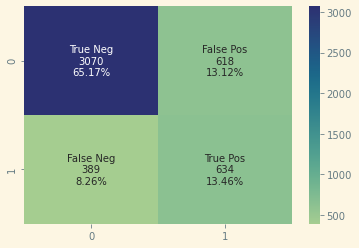

In [59]:
cf_matrix = metrics.confusion_matrix(log_y_pred_train, y_train)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

Training Accuracy:

In [60]:
log_train_as = metrics.accuracy_score(log_y_pred_train, y_train)
print(f"Accuracy score for train data : {log_train_as}\n")

Accuracy score for train data : 0.7862449586075143



Test Confusion Matrix:

<AxesSubplot:>

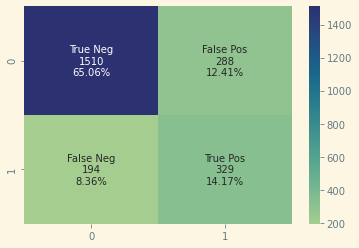

In [61]:
cf_matrix = metrics.confusion_matrix(log_y_pred, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

    Test Accuracy:

In [62]:
log_test_as = metrics.accuracy_score(log_y_pred, y_test)
print(f"Accuracy score for test data : {log_test_as}\n")

Accuracy score for test data : 0.7923308918569582



In [63]:
print(metrics.classification_report(log_y_pred, y_test))


              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1798
           1       0.53      0.63      0.58       523

    accuracy                           0.79      2321
   macro avg       0.71      0.73      0.72      2321
weighted avg       0.81      0.79      0.80      2321



#### Recall:
our recall score of 0.66 for positive identification of customer churn is a little worrying, while not bad, this is the
most important metric for our particular problem, a fals positive is not as damaging to company profits as a false negative,
so we hope to raise this score in future iterations.
F-Score:

#### Accuracy:
Our overall accuracy is not bad at all for a first evaluation of our model,
 it doesn't appear that we've overfit on our test data, .80 is encouraging.

#### Precision:
For this particular problem the cost of identifying a false positive is not very high, so while our precision metric
for identifying a churning customer is not particularly high, it is also not concerning, we would still like to improve
it in our next itteration.
#### ROC:
Our ROC indicates a good start for our model.


In [64]:
y_proba_log = log.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba_log)

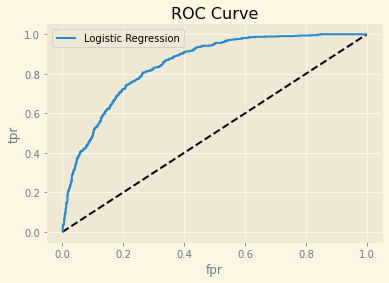

In [65]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

In [66]:
metrics.roc_auc_score(y_test, y_proba_log)
y_proba_log_train = log.predict_proba(X_train)[:, 1]
metrics.roc_auc_score(y_train, y_proba_log_train)

0.8267304258834897

Now let's see if hyperparameter tuning can improve our model, we should focus on improving our recall score:

In [67]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=log, param_grid=grid, n_jobs=-1, cv=cv, scoring='recall',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.541796 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.534315 (0.031024) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.524684 (0.029715) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.541796 (0.035789) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.534494 (0.030620) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.529320 (0.032539) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.541796 (0.035708) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.533959 (0.030844) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.532347 (0.038466) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.541796 (0.035680) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.524152 (0.029623) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.524682 (0.032500) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.532345 (0.039873) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.481169 (0.029091) wit

In [68]:
log = LogisticRegression(C=100, penalty='l2', solver='newton-cg')
log.fit(X_train, y_train)

log_y_pred = log.predict(X_test)
log_y_pred_train = log.predict(X_train)
print(metrics.classification_report(log_y_pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1804
           1       0.53      0.63      0.58       517

    accuracy                           0.79      2321
   macro avg       0.71      0.74      0.72      2321
weighted avg       0.81      0.79      0.80      2321



In [69]:
k = 5
kf = KFold(n_splits=k, random_state=None)

result = cross_val_score(log , X, y, cv = kf)
mean = round(result.mean()*100, 2)
stdv = round(result.std()*100, 2)
range = [round(mean-stdv, 2), round(mean+stdv ,2)]

print("Avg accuracy: {}% +/- {}%\n range: {}".format(mean, stdv, range))



Avg accuracy: 78.91% +/- 0.39%
 range: [78.52, 79.3]


After running our logistic regression model with the relevant optimized hyper parameters, we didn't see that much
of an improvement, we actually had a somewhat worse result, so I would recommend using the previous model parameters.